In [1]:
import sys 
import os

import numpy as np
import matplotlib.pyplot as plt



from pybandstructure import *

import graphene

In [2]:
#################### graphene parameters #######################################
#distances in nm, energies in eV
#a = np.sqrt(3) *0.142
E_SQUARED = 1.4399764
a = 0.246 #[nm] lattice constant of graphene
#hv = 0.57 #hbar v_D [eV*nm]
#t0 = -2.6755256377 #t0 = -3.089
#hv = np.sqrt(3)/2 * a * abs(t0) 
hv = 0.658
#################################################################################
theta = 1.08 #twist angle [deg]
uAB = 0.#0.110 #AB interlayer coupling [eV]
uAA = 0.#0.110  #AA interlayer coupling [eV]
uAB_nl = -0.*uAB  #AB non-local interlayer coupling [eV]
uAA_nl = -0.*uAA  #AA non-local interlayer coupling [eV]
valley = 1
density = 0. #electron density in [nm^-2]
temperature = 0.026 #k_B T [eV]
#################### computational parameters ##################################
n_sites = 18# number of unit cells of the crystal in one direction !must be multiple of 6!
G_max = 3.001 #number of shells considered in reciprocal space
n_bands = 1#number of bands calculated below and above Dirac point
eta = 0.0001 #energy smoothing [eV]
####################### Output folder ##########################################
output_folder = 'test_output'
file_name = 'tblg'
################################################################################

In [3]:
model = koshino(valley = valley, uAA = uAA, uAB = uAB, uAA_nl = uAA_nl, uAB_nl = uAB_nl,
                theta = theta, hv = hv, a = a, G_max = G_max)

g = np.linalg.norm(model['reciprocal_lattice_vectors'].get_coords((1,0)))
######################### Point group ###########################################
point_group = Point_Group.dihedral_group(n = 3,
                                         theta0 = np.arctan2(model['reciprocal_lattice_vectors'].basis_vectors[1,0], 
                                                             model['reciprocal_lattice_vectors'].basis_vectors[0,0]))
#point_group = Point_Group.trivial_group(space_dimension=2)
#################################################################################
lattice_geometry = Crystal_Geometry(reciprocal_lattice_basis = model['reciprocal_lattice_vectors'].basis_vectors, 
                                    point_group = point_group)
######
Mxy = int(n_sites/2)
Kxy = int(n_sites/3)
special_points = {'$\Gamma$': (0, 0), '$M$': (Mxy, 0), '$M^\prime$': (0, Mxy), '$K$': (Kxy, Kxy)}
########## Default u.c. ##########################
#k_sample = Unit_Cell_Sample.default_unit_cell(basis_vectors= model['reciprocal_lattice_vectors'].basis_vectors, 
#                                              denominator=n_sites,
#                                              special_points = special_points)
########## Reduced sample ########################
k_sample = Unit_Cell_Sample.irreducible_wigner_seitz_cell(
    basis_vectors= model['reciprocal_lattice_vectors'].basis_vectors, 
    denominator=n_sites, 
    point_group = point_group, 
    special_points = special_points)
##### Precompiled sample #########################
#k_sample = Unit_Cell_Sample.irreducible_sample(name = '2D_Hexagonal_D3_Axes',
#                                               basis_vectors= model['reciprocal_lattice_vectors'].basis_vectors, 
#                                               denominator=n_sites)
q_sample = Unit_Cell_Sample.wigner_seitz_cell(basis_vectors= model['reciprocal_lattice_vectors'].basis_vectors, 
                                               denominator=n_sites, special_points=special_points)

In [4]:
first_shell_1 = [(1,0), (0,-1),(-1,1)]
first_shell_2 = [(-1,0),(0,1),(1,-1)]
potential_components_S = np.zeros([len(model['reciprocal_lattice_vectors'])], dtype = complex)
for key in first_shell_1:
    potential_components_S[model['reciprocal_lattice_vectors'][key]] = 1./6.
for key in first_shell_2:
    potential_components_S[model['reciprocal_lattice_vectors'][key]] = 1./6.

US = build_potential_hamiltonian(U = np.eye(4, dtype = complex), 
                                  potential_components = potential_components_S, 
                                  reciprocal_lattice_vectors = model['reciprocal_lattice_vectors'])
#########################################################################################################################
potential_components_A = np.zeros([len(model['reciprocal_lattice_vectors'])], dtype = complex)
for key in first_shell_1:
    potential_components_A[model['reciprocal_lattice_vectors'][key]] = -1.j/6
for key in first_shell_2:
    potential_components_A[model['reciprocal_lattice_vectors'][key]] = 1.j/6
UA = build_potential_hamiltonian(U = np.eye(4, dtype = complex), 
                                  potential_components = potential_components_A, 
                                  reciprocal_lattice_vectors = model['reciprocal_lattice_vectors'])

In [5]:
kf_vals = 1/np.linspace(0.5/g, 10/g,num=20)
chi = []
for kf in kf_vals:
    density = 2.* kf**2/ np.pi
    uS = .0001 * max(temperature, hv* kf)#[eV]
    uA = .0002 * max(temperature, hv* kf)#[eV]
    H = model['hamiltonian'] + 6. * uS *US + 6. * uA * UA
    H.collapse_constant_coefficients()
    band_structure = Band_Structure.from_hamiltonian(
        k_sample = k_sample,
        hamiltonian = H,
        degeneracy = 4,
        zero_filling = 2*len(model['reciprocal_lattice_vectors']),
        density = density,
        temperature = temperature)
    band_structure.compute_bands()
    nS = band_structure.average_operator(US) 
    #nA = band_structure.average_operator(UA) 
    #print(np.allclose(nS/uS,nA/uA))
    #print(nS/uS ,nA/uA)
    print(np.real(nS/uS), 2 * np.real(graphene.chi(omega = 0, q= g, Ef = band_structure.chemical_potential)))
    chi.append(nS/uS)

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:06<00:00,  9.58it/s]


-1.8546563213647638 -2.1469903359922498


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:06<00:00,  9.81it/s]


-1.0191426420038567 -1.0667274294916886


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:06<00:00, 10.35it/s]


-0.6595977808150385 -0.703600816507427


  0%|                                                                                           | 0/64 [00:00<?, ?it/s]

-0.5028967154396373 -0.5228211825868787


  0%|                                                                                           | 0/64 [00:00<?, ?it/s]

-0.4397150855241939 -0.4657384395284113


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:06<00:00,  9.65it/s]


-0.41261275827076 -0.44473395240613717


  0%|                                                                                           | 0/64 [00:00<?, ?it/s]

-0.39922371024790754 -0.4349906283324408


  0%|                                                                                           | 0/64 [00:00<?, ?it/s]

-0.39181235887319427 -0.4299150690841417


  0%|                                                                                           | 0/64 [00:00<?, ?it/s]

-0.38735946751158623 -0.4270683233719805


  0%|                                                                                           | 0/64 [00:00<?, ?it/s]

-0.38452039867134413 -0.42538870551429536


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:06<00:00, 10.54it/s]


-0.38262907418603737 -0.42436103875498593


  0%|                                                                                           | 0/64 [00:00<?, ?it/s]

-0.38132661262205414 -0.4237148899277661


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:06<00:00,  9.51it/s]


-0.38040622755909625 -0.4232997597516144


  0%|                                                                                           | 0/64 [00:00<?, ?it/s]

-0.3797421877794406 -0.42302816720211434


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:07<00:00,  8.33it/s]


-0.3792547034989658 -0.4228475869431945


  0%|                                                                                           | 0/64 [00:00<?, ?it/s]

-0.3788914018926952 -0.42272570154582717


  0%|                                                                                           | 0/64 [00:00<?, ?it/s]

-0.37861697982657483 -0.4226422432289525


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:07<00:00,  8.63it/s]


-0.37840712993989634 -0.42258429801598074


  0%|                                                                                           | 0/64 [00:00<?, ?it/s]

-0.37824482135968684 -0.42254352133542283


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:07<00:00,  8.57it/s]

-0.3781179427537043 -0.42251445021505524


(0, 4)

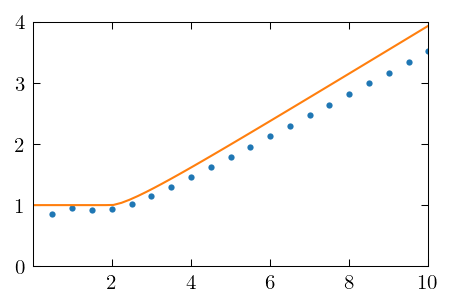

In [6]:
plt.plot(g/kf_vals, -np.array(np.real(chi))/(4*kf_vals/(np.pi * hv)),'o')

q= np.linspace(0.00001,10) 
plt.plot(q, -np.real(graphene.chi(omega = 0., q = q, Ef = hv)/(2 /(np.pi*hv))))
plt.ylim(0,4)

In [7]:
tblg = Crystal(geometry = lattice_geometry,
                   band_structure=band_structure, 
               eta = eta)

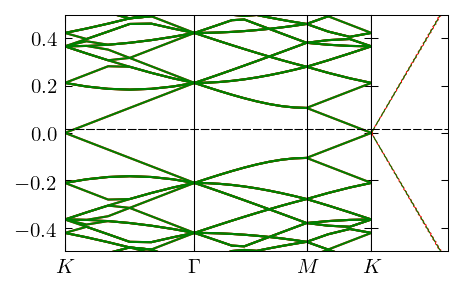

In [8]:
e_lims = -.5,.5 #energy limits for the figure
e_vals = np.linspace(*e_lims,num=200)
tblg.eta = 0.005
dosvals = tblg.dos(e_vals, shape = 'fermi')
plt.figure()
plt.axes([0.2,0.2,0.6,0.75])
_ = tblg.band_structure.plot([r'$K$', r'$\Gamma$', r'$M^\prime$', r'$K$'], c='r',emin = e_lims[0], emax=e_lims[1])
_ = tblg.band_structure.plot([r'$K$', r'$\Gamma$', r'$M$', r'$K$'],c='g',emin = e_lims[0], emax=e_lims[1])
plt.ylim(e_lims[0],e_lims[-1])
#plt.yticks(np.arange(-0.01,0.03,0.005))
ax = plt.axes([0.8,0.2,0.15,0.75])
ax.yaxis.set_label_position("right")
ax.set_xticks([])
ax.set_yticklabels([])
plt.ylim(e_lims[0],e_lims[-1])
plt.xlim(0,1.1*np.amax(dosvals))
plt.plot(dosvals ,e_vals, c='r',lw=0.5)
plt.plot(abs(e_vals)*4/(np.pi * hv**2),e_vals,'--', c='g', lw=0.5)
plt.plot([0,1.1*np.amax(dosvals)],[tblg.band_structure.chemical_potential,tblg.band_structure.chemical_potential],'--',c='k', lw=0.5)

In [9]:
if False:
    band_structure.compute_bands(eigvals = (4 * len(model['reciprocal_lattice_vectors']) // 2 - n_bands,
                                        4 * len(model['reciprocal_lattice_vectors']) // 2 + n_bands - 1))

In [10]:
if False:
    sl = slice(4 * len(model['reciprocal_lattice_vectors']) // 2 - 4, 4 * len(model['reciprocal_lattice_vectors']) // 2 +4)
    print(np.round(tblg.band_structure.energies[:, tblg.band_structure.k_sample['$\Gamma$']],5))
    print(np.round(tblg.band_structure.energies[:, tblg.band_structure.k_sample['$K$']],5))
    print(np.round(tblg.band_structure.energies[:, tblg.band_structure.k_sample['$M$']],5))

In [11]:
eps_sub = 4.
g = np.linalg.norm(model['reciprocal_lattice_vectors'].get_coords((1,0)))
alpha = np.real(2*np.pi * E_SQUARED/(eps_sub *g))


print(alpha)
uS = .1 #[eV]
uA = .02 #[eV]
H = model['hamiltonian'] + 6. * uS *US + 6. * uA * UA
H.collapse_constant_coefficients()
band_structure = Band_Structure.from_hamiltonian(
        k_sample = k_sample,
        hamiltonian = H,
        degeneracy = 4,
        zero_filling = 2*len(model['reciprocal_lattice_vectors']),
        density = density,
        temperature = temperature)

eps = 1-2 * alpha * graphene.chi(omega = 0., q = g, Ef = hv * np.sqrt(np.pi/2 *density))
chi_H = 2 *np.real(graphene.chi(omega = 0., q = g, Ef = hv * np.sqrt(np.pi/2 *density))/eps)

sol = band_structure.compute_sc_bands(operators = [US, UA], 
                                transfer_function = lambda x:[np.real(6. * alpha * x[0]),
                                                               np.real(6. * alpha * x[1])], 
                                      initial_values = [chi_H * uS , chi_H * uA], 
                                      eigvals = None,

                                      options ={'method' : 'broyden1',
                                                 'callback' : print,})

4.068800800896834


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:06<00:00, 10.17it/s]


[-0.01554682 -0.00310938] [0.00128118 0.0002159 ]


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:06<00:00, 10.26it/s]


[-0.01552601 -0.00316166] [0.00122684 0.00035165]


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:07<00:00,  8.33it/s]


[-0.01508494 -0.00292812] [ 3.96727421e-05 -2.69048501e-04]


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:06<00:00, 10.38it/s]


[-0.01506944 -0.0030293 ] [ 7.69768242e-07 -5.05673925e-06]
     fun: array([ 7.69768242e-07, -5.05673925e-06])
 message: 'A solution was found at the specified tolerance.'
     nit: 5
  status: 1
 success: True
       x: array([-0.01506944, -0.0030293 ])


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:04<00:00, 13.86it/s]


In [12]:
(uS +1j *uA) /(uS +1j *uA+  alpha* sol.x[0] +1j * alpha * sol.x[1] )

(2.5857498983254765+0.004032966117940181j)

In [13]:
1-2 *alpha * graphene.chi(omega = 0., q = g, Ef = band_structure.chemical_potential)

(2.7191132035771335+0j)

In [14]:
tblg = Crystal(geometry = lattice_geometry,
                   band_structure=band_structure, 
               eta = eta)

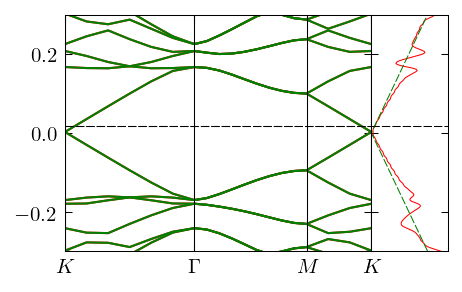

In [15]:
e_lims = -0.3,0.3 #energy limits for the figure
e_vals = np.linspace(*e_lims,num=200)
tblg.eta = 0.005
dosvals = tblg.dos(e_vals, shape = 'fermi')
plt.figure()
plt.axes([0.2,0.2,0.6,0.75])
_ = tblg.band_structure.plot([r'$K$', r'$\Gamma$', r'$M^\prime$', r'$K$'], c='r',emin = e_lims[0], emax=e_lims[1])
_ = tblg.band_structure.plot([r'$K$', r'$\Gamma$', r'$M$', r'$K$'],c='g',emin = e_lims[0], emax=e_lims[1])
plt.ylim(e_lims[0],e_lims[-1])
#plt.yticks(np.arange(-0.01,0.03,0.005))
ax = plt.axes([0.8,0.2,0.15,0.75])
ax.yaxis.set_label_position("right")
ax.set_xticks([])
ax.set_yticklabels([])
plt.ylim(e_lims[0],e_lims[-1])
plt.xlim(0,1.1*np.amax(dosvals))
plt.plot(dosvals ,e_vals, c='r',lw=0.5)
plt.plot(abs(e_vals)*4/(np.pi * hv**2),e_vals,'--', c='g', lw=0.5)
plt.plot([0,1.1*np.amax(dosvals)],[tblg.band_structure.chemical_potential,tblg.band_structure.chemical_potential],'--',c='k', lw=0.5)

In [16]:
kf_vals = 1/np.linspace(0.5/g, 10/g,num=5)
chi = []
for kf in kf_vals:
    density = 2.* kf**2/ np.pi
    uS = .0001 * max(temperature, hv* kf)#[eV]
    uA = .0002 * max(temperature, hv* kf)#[eV]
    H = model['hamiltonian'] + 6. * uS *US + 6. * uA * UA
    H.collapse_constant_coefficients()
    band_structure = Band_Structure.from_hamiltonian(
        k_sample = k_sample,
        hamiltonian = H,
        degeneracy = 4,
        zero_filling = 2*len(model['reciprocal_lattice_vectors']),
        density = density,
        temperature = temperature)
    eps = 1-2 * alpha * graphene.chi(omega = 0., q = g, Ef = hv * np.sqrt(np.pi/2 *density))
    chi_H = np.real(graphene.chi(omega = 0., q = g, Ef = hv * np.sqrt(np.pi/2 *density))/eps)

    sol = band_structure.compute_sc_bands(operators = [US, UA], 
                                transfer_function = lambda x:[np.real(6. * alpha * x[0]),
                                                               np.real(6. * alpha * x[1])], 
                                      initial_values = [chi_H * uS , chi_H * uA], 
                                      eigvals = None,

                                      options ={'method' : 'broyden1',
                                                 'callback' : print,})
    nS = band_structure.average_operator(US) 
    #nA = band_structure.average_operator(UA) 
    #print(np.allclose(nS/uS,nA/uA))
    #print(nS/uS ,nA/uA)
    print(np.real(nS/uS), 2 * np.real(graphene.chi(omega = 0, q= g, Ef = band_structure.chemical_potential)))
    chi.append(nS/uS)

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:06<00:00, 10.07it/s]


[-8.07057704e-06 -1.61411542e-05] [-6.67152251e-05 -1.33433994e-04]


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:06<00:00,  9.92it/s]


[-2.33652244e-05 -2.80099055e-05] [ 6.40065471e-05 -3.19980032e-05]


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:06<00:00, 10.40it/s]


[-2.23055341e-05 -2.85397366e-05] [ 5.49491959e-05 -2.74690420e-05]


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:06<00:00, 10.39it/s]


[-1.58768641e-05 -3.17531334e-05] [ 1.62003496e-09 -2.00405356e-09]
     fun: array([ 1.62003496e-09, -2.00405356e-09])
 message: 'A solution was found at the specified tolerance.'
     nit: 5
  status: 1
 success: True
       x: array([-1.58768641e-05, -3.17531334e-05])


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:06<00:00,  9.75it/s]


-0.21699798367106937 -2.14699037170884


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:06<00:00, 10.65it/s]
C:\Users\Windows\anaconda3\lib\site-packages\scipy\optimize\nonlin.py:475: RuntimeWarning: invalid value encountered in double_scalars
  and dx_norm/self.x_rtol <= x_norm))
100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:06<00:00, 10.18it/s]


[-1.01539862e-06 -2.03079723e-06] [-2.57251389e-06 -5.14494123e-06]
     fun: array([-2.57251389e-06, -5.14494123e-06])
 message: 'A solution was found at the specified tolerance.'
     nit: 2
  status: 1
 success: True
       x: array([-1.01539862e-06, -2.03079723e-06])


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:06<00:00, 10.07it/s]


-0.28199731726215366 -0.44849049864066437


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:06<00:00, 10.31it/s]


[-5.43655805e-07 -1.08731161e-06] [-1.27997455e-06 -2.55994147e-06]
     fun: array([-1.27997455e-06, -2.55994147e-06])
 message: 'A solution was found at the specified tolerance.'
     nit: 2
  status: 1
 success: True
       x: array([-5.43655805e-07, -1.08731161e-06])


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:06<00:00,  9.93it/s]


-0.26173475706765403 -0.42481407258631587


  0%|                                                                                           | 0/64 [00:00<?, ?it/s]

[-3.73216622e-07 -7.46433243e-07] [-8.69926702e-07 -1.73985170e-06]
     fun: array([-8.69926702e-07, -1.73985170e-06])
 message: 'A solution was found at the specified tolerance.'
     nit: 2
  status: 1
 success: True
       x: array([-3.73216622e-07, -7.46433243e-07])


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:06<00:00,  9.32it/s]


-0.2591351540682767 -0.4228125656008122


  0%|                                                                                           | 0/64 [00:00<?, ?it/s]

[-2.84352432e-07 -5.68704864e-07] [-6.61301586e-07 -1.32260260e-06]
     fun: array([-6.61301586e-07, -1.32260260e-06])
 message: 'A solution was found at the specified tolerance.'
     nit: 2
  status: 1
 success: True
       x: array([-2.84352432e-07, -5.68704864e-07])


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:07<00:00,  8.91it/s]

-0.2585220288675527 -0.42251445021593026
